In [1]:
import pandas as pd
import numpy as np

### Data

In [2]:
data1 = pd.read_csv('../../Data/Jeju/201901-202003.csv')
data1 = data1.fillna('')
data2 = pd.read_csv('../../Data/Jeju/202004.csv')
data2 = data2.fillna('')

In [3]:
data = pd.concat([data1, data2])

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26048114 entries, 0 to 1350321
Data columns (total 12 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   REG_YYMM      int64 
 1   CARD_SIDO_NM  object
 2   CARD_CCG_NM   object
 3   STD_CLSS_NM   object
 4   HOM_SIDO_NM   object
 5   HOM_CCG_NM    object
 6   AGE           object
 7   SEX_CTGO_CD   int64 
 8   FLC           int64 
 9   CSTMR_CNT     int64 
 10  AMT           int64 
 11  CNT           int64 
dtypes: int64(6), object(6)
memory usage: 2.5+ GB


In [5]:
data.head(1)

,REG_YYMM,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,HOM_SIDO_NM,HOM_CCG_NM,AGE,SEX_CTGO_CD,FLC,CSTMR_CNT,AMT,CNT
0,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,20s,1,1,4,311200,4


In [6]:
data['STD_CLSS_NM'].unique()

array(['건강보조식품 소매업', '골프장 운영업', '과실 및 채소 소매업', '관광 민예품 및 선물용품 소매업',
       '그외 기타 스포츠시설 운영업', '그외 기타 종합 소매업', '기타 대형 종합 소매업', '기타 외국식 음식점업',
       '기타 주점업', '기타음식료품위주종합소매업', '마사지업', '비알콜 음료점업', '빵 및 과자류 소매업',
       '서양식 음식점업', '수산물 소매업', '슈퍼마켓', '스포츠 및 레크레이션 용품 임대업', '여관업', '욕탕업',
       '육류 소매업', '일반유흥 주점업', '일식 음식점업', '전시 및 행사 대행업', '중식 음식점업',
       '차량용 가스 충전업', '차량용 주유소 운영업', '체인화 편의점', '피자 햄버거 샌드위치 및 유사 음식점업',
       '한식 음식점업', '호텔업', '화장품 및 방향제 소매업', '휴양콘도 운영업', '여행사업', '자동차 임대업',
       '면세점', '버스 운송업', '택시 운송업', '기타 수상오락 서비스업', '내항 여객 운송업',
       '그외 기타 분류안된 오락관련 서비스업', '정기 항공 운송업'], dtype=object)

In [19]:
data[(data['CARD_SIDO_NM'] == '제주') & (data['STD_CLSS_NM'] == '여행사업')].groupby('REG_YYMM').sum()

,SEX_CTGO_CD,FLC,CSTMR_CNT,AMT,CNT
REG_YYMM,,,,,
201901,193,336,519,27989356,547
201902,233,404,608,26272140,650
201903,222,432,609,25522820,640
201904,169,328,507,38257008,557
201905,162,336,476,39781170,534
201906,234,440,690,44820130,767
201907,231,434,687,75309116,750
201908,397,734,1223,105812605,1328
201909,143,246,402,30092930,435


In [ ]:
data

#### 결측 처리

In [15]:
data.loc[data.CARD_CCG_NM.isna(),'CARD_CCG_NM'] = '세종'
data.loc[data.HOM_CCG_NM.isna(),'HOM_CCG_NM'] = '세종'

#### 18 사업체총조사

In [16]:
all_jobs_df = pd.read_csv('data/18 사업체총조사_키워드매칭.csv',encoding = 'cp949')
all_jobs_df = all_jobs_df[['행정구역별','데이터업종명','사업체수 (개)', '종사자수 (명)']]
all_jobs_df.columns = ['CARD_SIDO_NM','STD_CLSS_NM', 'company','employee']
all_jobs_df.employee = all_jobs_df.employee.apply(lambda x : x.replace("X","0")).astype(int)
all_jobs_df = all_jobs_df.groupby(['CARD_SIDO_NM','STD_CLSS_NM'])[['company','employee']].sum().reset_index()

all_jobs_df = all_jobs_df[~(all_jobs_df.CARD_SIDO_NM == '전국')]

#### 지역내 각 업종이 차지하는 매출비중

In [17]:
def local_percent(data):
    pivoted = data.pivot_table(index = ['CARD_SIDO_NM','CARD_CCG_NM','STD_CLSS_NM'],columns ='REG_YYMM',values= "AMT",aggfunc='sum').reset_index()
    pivoted.fillna(0,inplace= True)

    #각 지역별(시군구)업종의 매출비율을 저장
    sidos = pivoted.CARD_SIDO_NM.unique()

    local_percent_df = pd.DataFrame()
    for sido in sidos:
        sample_sido = pivoted[pivoted.CARD_SIDO_NM == sido]
        sigungus = sample_sido.CARD_CCG_NM.unique()
        for sigungu in sigungus:
            sample = sample_sido[sample_sido.CARD_CCG_NM == sigungu]
            sum_arr = sample.iloc[:,3:].sum().values.reshape(1,-1)
            parcent_df = (sample.iloc[:,3:]/sum_arr)*100

            fin = pd.concat([sample.iloc[:,:3],parcent_df],axis=1)
            local_percent_df = pd.concat([local_percent_df,fin])

    #신규변수 LP(local percent) : 지역내 각 업종이 차지하는 매출비중
    local_percent_df = local_percent_df.melt(id_vars=['CARD_SIDO_NM','CARD_CCG_NM','STD_CLSS_NM'],value_name='LP')
    return local_percent_df

#### 전체업종에서 각 지역업종이 차지하는 매출비중

In [18]:
def job_percent(data):
    pivoted = data.pivot_table(index = ['CARD_SIDO_NM','CARD_CCG_NM','STD_CLSS_NM'],columns ='REG_YYMM',values= "AMT",aggfunc='sum').reset_index()
    pivoted.fillna(0,inplace= True)

    all_pivoted = data.pivot_table(index = ['STD_CLSS_NM'],columns ='REG_YYMM',values= "AMT",aggfunc= 'sum').reset_index()
    all_pivoted.fillna(0,inplace= True)
    all_pivoted = all_pivoted.set_index('STD_CLSS_NM')

    job_percent_df = pd.DataFrame()
    for job in all_pivoted.index:
        taget_df = pivoted[pivoted.STD_CLSS_NM == job]
        tail = (taget_df.iloc[:,3:]/all_pivoted.iloc[0].values)*100
        head = taget_df.iloc[:,:3]
        full = pd.concat([head,tail],axis =1)
        job_percent_df = pd.concat([job_percent_df,full])

    #신규변수 JP(Job percent): 전체업종에서 해당지역의 업종이 차이하는 비율
    job_percent_df = job_percent_df.melt(id_vars=['CARD_SIDO_NM','CARD_CCG_NM','STD_CLSS_NM'],value_name='JP')
    return job_percent_df

#### 거래횟수와 이용고객과의 관계 (2019)

In [19]:
def cust_differ(data):
    data['differ'] = (data.CNT- data.CSTMR_CNT)
    
    #양수(단골)
    plus_custom = data[data['differ']>0]
    pivot_plus = plus_custom.pivot_table(index = ['CARD_SIDO_NM','STD_CLSS_NM'],columns = 'REG_YYMM', values= 'differ', aggfunc ='sum').reset_index()
    
    melt_plus = pivot_plus.melt(id_vars=['CARD_SIDO_NM','STD_CLSS_NM'],value_name='loyal')
    melt_plus['year'] = melt_plus['REG_YYMM'].apply(lambda x: int(str(x)[:4]))
    melt_plus['month'] = melt_plus['REG_YYMM'].apply(lambda x: int(str(x)[5:]))
    
    #2019만 사용
    melt_plus = melt_plus[melt_plus.year == 2019]
    melt_plus.drop(['year'],axis= 1,inplace = True)
    
    #음수(환불)
    minus_custom = data[data['differ']<0]
    pivot_minus = minus_custom.pivot_table(index = ['CARD_SIDO_NM','STD_CLSS_NM'],columns = 'REG_YYMM', values= 'differ', aggfunc ='sum').reset_index()
    
    melt_minus = pivot_minus.melt(id_vars=['CARD_SIDO_NM','STD_CLSS_NM'],value_name='refund')
    melt_minus['year'] = melt_minus['REG_YYMM'].apply(lambda x: int(str(x)[:4]))
    melt_minus['month'] = melt_minus['REG_YYMM'].apply(lambda x: int(str(x)[5:]))
    #2019만 사용
    melt_minus = melt_minus[melt_minus.year == 2019]
    melt_minus.drop(['year'],axis= 1,inplace = True)
    
  
    #둘 결헙
    cust_differ_df = pd.merge(melt_plus,melt_minus,how= 'outer')
    
    return cust_differ_df

In [20]:
trade_num_2019 = cust_differ(data)

#### 거래횟수와 이용고객과의 관계 (2020)

In [21]:
def cust_differ_2020(data):
    data['differ'] = (data.CNT- data.CSTMR_CNT)
    
    #양수(단골)
    plus_custom = data[data['differ']>0]
    pivot_plus = plus_custom.pivot_table(index = ['CARD_SIDO_NM','STD_CLSS_NM'],columns = 'REG_YYMM', values= 'differ', aggfunc ='sum').reset_index()
    
    melt_plus = pivot_plus.melt(id_vars=['CARD_SIDO_NM','STD_CLSS_NM'],value_name='loyal')
    melt_plus['year'] = melt_plus['REG_YYMM'].apply(lambda x: int(str(x)[:4]))
    melt_plus['month'] = melt_plus['REG_YYMM'].apply(lambda x: int(str(x)[5:]))
    
    #2020만 사용
    melt_plus = melt_plus[melt_plus.year == 2020]
    melt_plus.drop(['year'],axis= 1,inplace = True)
    
    #음수(환불)
    minus_custom = data[data['differ']<0]
    pivot_minus = minus_custom.pivot_table(index = ['CARD_SIDO_NM','STD_CLSS_NM'],columns = 'REG_YYMM', values= 'differ', aggfunc ='sum').reset_index()
    
    melt_minus = pivot_minus.melt(id_vars=['CARD_SIDO_NM','STD_CLSS_NM'],value_name='refund')
    melt_minus['year'] = melt_minus['REG_YYMM'].apply(lambda x: int(str(x)[:4]))
    melt_minus['month'] = melt_minus['REG_YYMM'].apply(lambda x: int(str(x)[5:]))
    #2020만 사용
    melt_minus = melt_minus[melt_minus.year == 2020]
    melt_minus.drop(['year'],axis= 1,inplace = True)
    
  
    #둘 결헙
    cust_differ_df = pd.merge(melt_plus,melt_minus,how= 'outer')
    
    return cust_differ_df

In [22]:
trade_num_2020 = cust_differ_2020(data)

In [23]:
trade_num = pd.concat([trade_num_2019, trade_num_2020])

In [24]:
trade_num.loyal = trade_num.loyal.fillna(-999)
trade_num.refund = trade_num.refund.fillna(999)

In [25]:
trade_num

,CARD_SIDO_NM,STD_CLSS_NM,REG_YYMM,loyal,month,refund
0,강원,건강보조식품 소매업,201901.0,80.0,1,-32.0
1,강원,골프장 운영업,201901.0,14890.0,1,999.0
2,강원,과실 및 채소 소매업,201901.0,7484.0,1,999.0
3,강원,관광 민예품 및 선물용품 소매업,201901.0,195.0,1,999.0
4,강원,그외 기타 분류안된 오락관련 서비스업,201901.0,-999.0,1,999.0
...,...,...,...,...,...,...
2575,충북,휴양콘도 운영업,202004.0,62.0,4,999.0
2576,대전,여행사업,202001.0,-999.0,1,999.0
2577,대전,여행사업,202002.0,-999.0,2,999.0
2578,대전,여행사업,202003.0,-999.0,3,999.0


#### 추가변수 결합

In [26]:
data.shape

(26048114, 13)

In [27]:
local_percent_df

,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,REG_YYMM,LP
0,강원,강릉시,건강보조식품 소매업,201901,0.138432
1,강원,강릉시,골프장 운영업,201901,0.148825
2,강원,강릉시,과실 및 채소 소매업,201901,1.468549
3,강원,강릉시,관광 민예품 및 선물용품 소매업,201901,0.022661
4,강원,강릉시,그외 기타 스포츠시설 운영업,201901,0.003255
...,...,...,...,...,...
124523,충북,충주시,피자 햄버거 샌드위치 및 유사 음식점업,202004,1.362619
124524,충북,충주시,한식 음식점업,202004,18.402971
124525,충북,충주시,호텔업,202004,0.059226
124526,충북,충주시,화장품 및 방향제 소매업,202004,0.368080


In [28]:
columns = ['REG_YYMM', 'CARD_SIDO_NM', 'CARD_CCG_NM', 'STD_CLSS_NM', 'HOM_SIDO_NM', 'AGE', 'SEX_CTGO_CD', 'FLC']
df = data.groupby(columns, as_index=False)[['AMT']].sum()

In [29]:
grouped = pd.merge(df,all_jobs_df,on =['CARD_SIDO_NM','STD_CLSS_NM'],how = 'left')
grouped = pd.merge(grouped,local_percent_df,on =['CARD_SIDO_NM','CARD_CCG_NM','STD_CLSS_NM','REG_YYMM'],how = 'left')
grouped = pd.merge(grouped,job_percent_df,on =['CARD_SIDO_NM','CARD_CCG_NM','STD_CLSS_NM','REG_YYMM'],how = 'left')
grouped = pd.merge(grouped, trade_num, on =['CARD_SIDO_NM','STD_CLSS_NM','REG_YYMM'], how = 'left')

In [30]:
local_percent_df = local_percent(data)
job_percent_df = job_percent(data)

In [31]:
grouped.head(5)

,REG_YYMM,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,HOM_SIDO_NM,AGE,SEX_CTGO_CD,FLC,AMT,company,employee,LP,JP,loyal,month,refund
0,201901,강원,강릉시,건강보조식품 소매업,강원,20s,1,1,311200,263.0,399.0,0.138432,0.279221,80.0,1.0,-32.0
1,201901,강원,강릉시,건강보조식품 소매업,강원,30s,1,2,1374500,263.0,399.0,0.138432,0.279221,80.0,1.0,-32.0
2,201901,강원,강릉시,건강보조식품 소매업,강원,30s,2,2,818700,263.0,399.0,0.138432,0.279221,80.0,1.0,-32.0
3,201901,강원,강릉시,건강보조식품 소매업,강원,40s,1,3,1717000,263.0,399.0,0.138432,0.279221,80.0,1.0,-32.0
4,201901,강원,강릉시,건강보조식품 소매업,강원,40s,1,4,1047300,263.0,399.0,0.138432,0.279221,80.0,1.0,-32.0


In [32]:
grouped.REG_YYMM = pd.to_datetime(grouped.REG_YYMM, format='%Y%m')

In [33]:
from sklearn.preprocessing import LabelEncoder

# 인코딩
dtypes = grouped.dtypes
encoders = {}
for column in grouped.columns:
    if str(dtypes[column]) == 'object':
        encoder = LabelEncoder()
        encoder.fit(grouped[column])
        encoders[column] = encoder
        
df_num = grouped.copy()        
for column in encoders.keys():
    encoder = encoders[column]
    df_num[column] = encoder.transform(grouped[column])

In [34]:
df_num

,REG_YYMM,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,HOM_SIDO_NM,AGE,SEX_CTGO_CD,FLC,AMT,company,employee,LP,JP,loyal,month,refund
0,2019-01-01,0,4,0,0,1,1,1,311200,263.0,399.0,0.138432,0.279221,80.0,1.0,-32.0
1,2019-01-01,0,4,0,0,2,1,2,1374500,263.0,399.0,0.138432,0.279221,80.0,1.0,-32.0
2,2019-01-01,0,4,0,0,2,2,2,818700,263.0,399.0,0.138432,0.279221,80.0,1.0,-32.0
3,2019-01-01,0,4,0,0,3,1,3,1717000,263.0,399.0,0.138432,0.279221,80.0,1.0,-32.0
4,2019-01-01,0,4,0,0,3,1,4,1047300,263.0,399.0,0.138432,0.279221,80.0,1.0,-32.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5630138,2020-04-01,16,202,40,16,1,1,1,77000,11.0,492.0,0.004580,0.011570,62.0,4.0,999.0
5630139,2020-04-01,16,202,40,16,2,1,2,92000,11.0,492.0,0.004580,0.011570,62.0,4.0,999.0
5630140,2020-04-01,16,202,40,16,3,2,3,193000,11.0,492.0,0.004580,0.011570,62.0,4.0,999.0
5630141,2020-04-01,16,202,40,16,4,1,4,86000,11.0,492.0,0.004580,0.011570,62.0,4.0,999.0


In [35]:
import datetime as dt

df_num['month'] = df_num['REG_YYMM'].dt.month
df_num['year'] = df_num['REG_YYMM'].dt.year

In [36]:
train_df = df_num[df_num['REG_YYMM'] <= '2020-01-01']
validation_df = df_num[(df_num['REG_YYMM'] > '2020-01-01') & (df_num['REG_YYMM'] <'2020-04-01')]

In [43]:
# 7월 데이터 = 2020년의 평균값을 사용.

temp = df_num[(df_num['REG_YYMM'] == '2020') | (df_num['REG_YYMM'] == '2019-07-01')]
temp = temp.groupby(['CARD_SIDO_NM', 'CARD_CCG_NM', 'STD_CLSS_NM',
                     'HOM_SIDO_NM', 'AGE', 'SEX_CTGO_CD', 'FLC'], as_index=False)[['company', 'employee', 
                                                            'LP', 'JP', 'loyal', 'month', 'refund', 'year']].mean()

In [45]:
temp

,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,HOM_SIDO_NM,AGE,SEX_CTGO_CD,FLC,company,employee,LP,JP,loyal,month,refund,year
0,0,4,0,0,1,2,1,263.0,399.0,0.142702,0.254024,93.0,1.0,-44.0,2020.0
1,0,4,0,0,2,1,2,263.0,399.0,0.142702,0.254024,93.0,1.0,-44.0,2020.0
2,0,4,0,0,2,2,2,263.0,399.0,0.107193,0.242553,86.5,4.0,-29.0,2019.5
3,0,4,0,0,3,1,3,263.0,399.0,0.142702,0.254024,93.0,1.0,-44.0,2020.0
4,0,4,0,0,3,1,4,263.0,399.0,0.142702,0.254024,93.0,1.0,-44.0,2020.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
428102,16,202,40,16,3,2,3,11.0,492.0,0.046522,0.079165,1362.5,4.0,-12.5,2019.5
428103,16,202,40,16,4,1,4,11.0,492.0,0.046522,0.079165,1362.5,4.0,-12.5,2019.5
428104,16,202,40,16,4,2,4,11.0,492.0,0.046522,0.079165,1362.5,4.0,-12.5,2019.5
428105,16,202,40,16,5,1,5,11.0,492.0,0.046522,0.079165,1362.5,4.0,-12.5,2019.5


In [46]:
temp.month = 7
temp = pd.concat([df_num[df_num['REG_YYMM'] == '2020-04-01'], temp])

In [47]:
temp = temp.drop(['REG_YYMM', 'AMT'], axis=1)

### Light GBM

In [49]:
import lightgbm as lgb

In [50]:
train_df.head(1)

,REG_YYMM,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,HOM_SIDO_NM,AGE,SEX_CTGO_CD,FLC,AMT,company,employee,LP,JP,loyal,month,refund,year
0,2019-01-01,0,4,0,0,1,1,1,311200,263.0,399.0,0.138432,0.279221,80.0,1,-32.0,2019


In [51]:
train = train_df.drop(['AMT', 'REG_YYMM'], axis=1)
trian_label = np.log1p(train_df[['AMT']])

In [52]:
validation = validation_df.drop(['AMT', 'REG_YYMM'], axis=1)
validation_label = np.log1p(validation_df[['AMT']])

In [53]:
lgb_train = lgb.Dataset(train, label=trian_label)
lgb_eval = lgb.Dataset(validation, label=validation_label, reference=lgb_train)

In [54]:
evals_result = {}
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'max_depth':11,
    'num_leaves': 31,
    'learning_rate': 0.4,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0}

In [55]:
model = lgb.train(params, lgb_train, early_stopping_rounds=100,
                  num_boost_round=5000, evals_result=evals_result,
                  valid_sets= (lgb_train, lgb_eval),)

[1]	training's rmse: 2.03599	valid_1's rmse: 2.02323
Training until validation scores don't improve for 100 rounds
[2]	training's rmse: 1.93696	valid_1's rmse: 1.9216
[3]	training's rmse: 1.8632	valid_1's rmse: 1.85076
[4]	training's rmse: 1.79592	valid_1's rmse: 1.77538
[5]	training's rmse: 1.76352	valid_1's rmse: 1.74555
[6]	training's rmse: 1.74287	valid_1's rmse: 1.72482
[7]	training's rmse: 1.69432	valid_1's rmse: 1.67408
[8]	training's rmse: 1.6805	valid_1's rmse: 1.66182
[9]	training's rmse: 1.65036	valid_1's rmse: 1.62335
[10]	training's rmse: 1.62514	valid_1's rmse: 1.60064
[11]	training's rmse: 1.61206	valid_1's rmse: 1.5897
[12]	training's rmse: 1.59828	valid_1's rmse: 1.57634
[13]	training's rmse: 1.58696	valid_1's rmse: 1.56568
[14]	training's rmse: 1.56697	valid_1's rmse: 1.56403
[15]	training's rmse: 1.53257	valid_1's rmse: 1.52719
[16]	training's rmse: 1.52618	valid_1's rmse: 1.52218
[17]	training's rmse: 1.51482	valid_1's rmse: 1.51351
[18]	training's rmse: 1.51105	val

[152]	training's rmse: 1.07191	valid_1's rmse: 1.12592
[153]	training's rmse: 1.07066	valid_1's rmse: 1.12491
[154]	training's rmse: 1.07022	valid_1's rmse: 1.12521
[155]	training's rmse: 1.06966	valid_1's rmse: 1.12476
[156]	training's rmse: 1.06769	valid_1's rmse: 1.12311
[157]	training's rmse: 1.06439	valid_1's rmse: 1.12063
[158]	training's rmse: 1.06362	valid_1's rmse: 1.12021
[159]	training's rmse: 1.06194	valid_1's rmse: 1.11902
[160]	training's rmse: 1.06158	valid_1's rmse: 1.11872
[161]	training's rmse: 1.06059	valid_1's rmse: 1.11821
[162]	training's rmse: 1.05892	valid_1's rmse: 1.11688
[163]	training's rmse: 1.05818	valid_1's rmse: 1.11652
[164]	training's rmse: 1.05754	valid_1's rmse: 1.11588
[165]	training's rmse: 1.05624	valid_1's rmse: 1.11482
[166]	training's rmse: 1.05531	valid_1's rmse: 1.11409
[167]	training's rmse: 1.05421	valid_1's rmse: 1.11324
[168]	training's rmse: 1.05342	valid_1's rmse: 1.11268
[169]	training's rmse: 1.05317	valid_1's rmse: 1.11245
[170]	trai

[301]	training's rmse: 0.958265	valid_1's rmse: 1.04543
[302]	training's rmse: 0.958059	valid_1's rmse: 1.04531
[303]	training's rmse: 0.9579	valid_1's rmse: 1.0452
[304]	training's rmse: 0.956969	valid_1's rmse: 1.04445
[305]	training's rmse: 0.956736	valid_1's rmse: 1.04434
[306]	training's rmse: 0.956304	valid_1's rmse: 1.04387
[307]	training's rmse: 0.956073	valid_1's rmse: 1.04375
[308]	training's rmse: 0.955491	valid_1's rmse: 1.04357
[309]	training's rmse: 0.954675	valid_1's rmse: 1.04295
[310]	training's rmse: 0.954057	valid_1's rmse: 1.04141
[311]	training's rmse: 0.953369	valid_1's rmse: 1.04102
[312]	training's rmse: 0.953084	valid_1's rmse: 1.0411
[313]	training's rmse: 0.952572	valid_1's rmse: 1.04088
[314]	training's rmse: 0.951792	valid_1's rmse: 1.04058
[315]	training's rmse: 0.951284	valid_1's rmse: 1.04006
[316]	training's rmse: 0.95007	valid_1's rmse: 1.03916
[317]	training's rmse: 0.948144	valid_1's rmse: 1.03812
[318]	training's rmse: 0.94637	valid_1's rmse: 1.0370

[448]	training's rmse: 0.899209	valid_1's rmse: 1.00632
[449]	training's rmse: 0.898836	valid_1's rmse: 1.00579
[450]	training's rmse: 0.898604	valid_1's rmse: 1.00543
[451]	training's rmse: 0.898447	valid_1's rmse: 1.00528
[452]	training's rmse: 0.898219	valid_1's rmse: 1.00516
[453]	training's rmse: 0.897985	valid_1's rmse: 1.00497
[454]	training's rmse: 0.897838	valid_1's rmse: 1.00486
[455]	training's rmse: 0.897735	valid_1's rmse: 1.00475
[456]	training's rmse: 0.897368	valid_1's rmse: 1.0045
[457]	training's rmse: 0.897237	valid_1's rmse: 1.00445
[458]	training's rmse: 0.897063	valid_1's rmse: 1.00437
[459]	training's rmse: 0.896748	valid_1's rmse: 1.00402
[460]	training's rmse: 0.896499	valid_1's rmse: 1.00399
[461]	training's rmse: 0.896306	valid_1's rmse: 1.00395
[462]	training's rmse: 0.896021	valid_1's rmse: 1.00388
[463]	training's rmse: 0.895787	valid_1's rmse: 1.0038
[464]	training's rmse: 0.895581	valid_1's rmse: 1.00364
[465]	training's rmse: 0.895404	valid_1's rmse: 1.

[595]	training's rmse: 0.858342	valid_1's rmse: 0.982592
[596]	training's rmse: 0.858055	valid_1's rmse: 0.982412
[597]	training's rmse: 0.857879	valid_1's rmse: 0.982326
[598]	training's rmse: 0.857633	valid_1's rmse: 0.982159
[599]	training's rmse: 0.857436	valid_1's rmse: 0.982034
[600]	training's rmse: 0.857231	valid_1's rmse: 0.981853
[601]	training's rmse: 0.857074	valid_1's rmse: 0.981854
[602]	training's rmse: 0.856861	valid_1's rmse: 0.981704
[603]	training's rmse: 0.856826	valid_1's rmse: 0.981792
[604]	training's rmse: 0.85674	valid_1's rmse: 0.982311
[605]	training's rmse: 0.856378	valid_1's rmse: 0.982251
[606]	training's rmse: 0.85624	valid_1's rmse: 0.982131
[607]	training's rmse: 0.85604	valid_1's rmse: 0.981981
[608]	training's rmse: 0.855864	valid_1's rmse: 0.981837
[609]	training's rmse: 0.855758	valid_1's rmse: 0.981744
[610]	training's rmse: 0.855702	valid_1's rmse: 0.98173
[611]	training's rmse: 0.855605	valid_1's rmse: 0.981738
[612]	training's rmse: 0.855334	val

[741]	training's rmse: 0.832443	valid_1's rmse: 0.970042
[742]	training's rmse: 0.83238	valid_1's rmse: 0.970024
[743]	training's rmse: 0.832072	valid_1's rmse: 0.969878
[744]	training's rmse: 0.831811	valid_1's rmse: 0.969472
[745]	training's rmse: 0.831765	valid_1's rmse: 0.969478
[746]	training's rmse: 0.831695	valid_1's rmse: 0.969486
[747]	training's rmse: 0.831598	valid_1's rmse: 0.969413
[748]	training's rmse: 0.831313	valid_1's rmse: 0.969308
[749]	training's rmse: 0.831134	valid_1's rmse: 0.969172
[750]	training's rmse: 0.831001	valid_1's rmse: 0.969124
[751]	training's rmse: 0.83088	valid_1's rmse: 0.969053
[752]	training's rmse: 0.830841	valid_1's rmse: 0.969039
[753]	training's rmse: 0.830745	valid_1's rmse: 0.968974
[754]	training's rmse: 0.830586	valid_1's rmse: 0.968918
[755]	training's rmse: 0.830359	valid_1's rmse: 0.968737
[756]	training's rmse: 0.830171	valid_1's rmse: 0.968623
[757]	training's rmse: 0.830134	valid_1's rmse: 0.968799
[758]	training's rmse: 0.830081	v

[886]	training's rmse: 0.811027	valid_1's rmse: 0.959502
[887]	training's rmse: 0.810905	valid_1's rmse: 0.95961
[888]	training's rmse: 0.810731	valid_1's rmse: 0.959536
[889]	training's rmse: 0.810579	valid_1's rmse: 0.95945
[890]	training's rmse: 0.810485	valid_1's rmse: 0.95937
[891]	training's rmse: 0.810319	valid_1's rmse: 0.959352
[892]	training's rmse: 0.810146	valid_1's rmse: 0.959114
[893]	training's rmse: 0.810018	valid_1's rmse: 0.958967
[894]	training's rmse: 0.809848	valid_1's rmse: 0.958941
[895]	training's rmse: 0.809754	valid_1's rmse: 0.958871
[896]	training's rmse: 0.809671	valid_1's rmse: 0.958753
[897]	training's rmse: 0.809545	valid_1's rmse: 0.958667
[898]	training's rmse: 0.809515	valid_1's rmse: 0.958656
[899]	training's rmse: 0.809423	valid_1's rmse: 0.958648
[900]	training's rmse: 0.809325	valid_1's rmse: 0.958527
[901]	training's rmse: 0.809263	valid_1's rmse: 0.958474
[902]	training's rmse: 0.809137	valid_1's rmse: 0.958435
[903]	training's rmse: 0.809056	va

[1030]	training's rmse: 0.79278	valid_1's rmse: 0.95049
[1031]	training's rmse: 0.792483	valid_1's rmse: 0.950329
[1032]	training's rmse: 0.792034	valid_1's rmse: 0.950212
[1033]	training's rmse: 0.791982	valid_1's rmse: 0.950206
[1034]	training's rmse: 0.79187	valid_1's rmse: 0.95003
[1035]	training's rmse: 0.791828	valid_1's rmse: 0.950031
[1036]	training's rmse: 0.791619	valid_1's rmse: 0.950074
[1037]	training's rmse: 0.791513	valid_1's rmse: 0.950052
[1038]	training's rmse: 0.791284	valid_1's rmse: 0.949914
[1039]	training's rmse: 0.791232	valid_1's rmse: 0.949858
[1040]	training's rmse: 0.791189	valid_1's rmse: 0.949831
[1041]	training's rmse: 0.791139	valid_1's rmse: 0.949821
[1042]	training's rmse: 0.791016	valid_1's rmse: 0.949765
[1043]	training's rmse: 0.790796	valid_1's rmse: 0.949624
[1044]	training's rmse: 0.790683	valid_1's rmse: 0.949687
[1045]	training's rmse: 0.790593	valid_1's rmse: 0.949611
[1046]	training's rmse: 0.790506	valid_1's rmse: 0.949618
[1047]	training's 

[1173]	training's rmse: 0.776858	valid_1's rmse: 0.941897
[1174]	training's rmse: 0.77659	valid_1's rmse: 0.941798
[1175]	training's rmse: 0.776444	valid_1's rmse: 0.941828
[1176]	training's rmse: 0.776184	valid_1's rmse: 0.941742
[1177]	training's rmse: 0.776148	valid_1's rmse: 0.941741
[1178]	training's rmse: 0.776099	valid_1's rmse: 0.941748
[1179]	training's rmse: 0.776035	valid_1's rmse: 0.941769
[1180]	training's rmse: 0.775965	valid_1's rmse: 0.941771
[1181]	training's rmse: 0.775824	valid_1's rmse: 0.941652
[1182]	training's rmse: 0.775688	valid_1's rmse: 0.941571
[1183]	training's rmse: 0.775575	valid_1's rmse: 0.941468
[1184]	training's rmse: 0.775423	valid_1's rmse: 0.941414
[1185]	training's rmse: 0.775326	valid_1's rmse: 0.941335
[1186]	training's rmse: 0.775265	valid_1's rmse: 0.941396
[1187]	training's rmse: 0.775239	valid_1's rmse: 0.941352
[1188]	training's rmse: 0.775204	valid_1's rmse: 0.941369
[1189]	training's rmse: 0.775124	valid_1's rmse: 0.941305
[1190]	training

[1315]	training's rmse: 0.762018	valid_1's rmse: 0.933867
[1316]	training's rmse: 0.761983	valid_1's rmse: 0.933907
[1317]	training's rmse: 0.761873	valid_1's rmse: 0.933916
[1318]	training's rmse: 0.76169	valid_1's rmse: 0.933753
[1319]	training's rmse: 0.761521	valid_1's rmse: 0.933706
[1320]	training's rmse: 0.761486	valid_1's rmse: 0.933707
[1321]	training's rmse: 0.7614	valid_1's rmse: 0.933663
[1322]	training's rmse: 0.761341	valid_1's rmse: 0.933632
[1323]	training's rmse: 0.761285	valid_1's rmse: 0.933604
[1324]	training's rmse: 0.761184	valid_1's rmse: 0.933584
[1325]	training's rmse: 0.761123	valid_1's rmse: 0.93356
[1326]	training's rmse: 0.760948	valid_1's rmse: 0.933708
[1327]	training's rmse: 0.760899	valid_1's rmse: 0.933675
[1328]	training's rmse: 0.76082	valid_1's rmse: 0.933548
[1329]	training's rmse: 0.760707	valid_1's rmse: 0.933465
[1330]	training's rmse: 0.760647	valid_1's rmse: 0.933493
[1331]	training's rmse: 0.760596	valid_1's rmse: 0.933407
[1332]	training's r

[1458]	training's rmse: 0.751111	valid_1's rmse: 0.929287
[1459]	training's rmse: 0.751032	valid_1's rmse: 0.929256
[1460]	training's rmse: 0.751011	valid_1's rmse: 0.929512
[1461]	training's rmse: 0.75091	valid_1's rmse: 0.929333
[1462]	training's rmse: 0.750862	valid_1's rmse: 0.929353
[1463]	training's rmse: 0.750845	valid_1's rmse: 0.929379
[1464]	training's rmse: 0.750723	valid_1's rmse: 0.929349
[1465]	training's rmse: 0.750687	valid_1's rmse: 0.929323
[1466]	training's rmse: 0.750646	valid_1's rmse: 0.929255
[1467]	training's rmse: 0.750547	valid_1's rmse: 0.929325
[1468]	training's rmse: 0.750401	valid_1's rmse: 0.92932
[1469]	training's rmse: 0.750286	valid_1's rmse: 0.92926
[1470]	training's rmse: 0.750257	valid_1's rmse: 0.929243
[1471]	training's rmse: 0.750159	valid_1's rmse: 0.929223
[1472]	training's rmse: 0.750069	valid_1's rmse: 0.929145
[1473]	training's rmse: 0.750033	valid_1's rmse: 0.929076
[1474]	training's rmse: 0.749979	valid_1's rmse: 0.929063
[1475]	training's

[1601]	training's rmse: 0.740165	valid_1's rmse: 0.926371
[1602]	training's rmse: 0.74011	valid_1's rmse: 0.92632
[1603]	training's rmse: 0.740061	valid_1's rmse: 0.926284
[1604]	training's rmse: 0.740024	valid_1's rmse: 0.926275
[1605]	training's rmse: 0.739987	valid_1's rmse: 0.926281
[1606]	training's rmse: 0.739963	valid_1's rmse: 0.926267
[1607]	training's rmse: 0.739938	valid_1's rmse: 0.926311
[1608]	training's rmse: 0.739881	valid_1's rmse: 0.926285
[1609]	training's rmse: 0.739862	valid_1's rmse: 0.926277
[1610]	training's rmse: 0.73981	valid_1's rmse: 0.926281
[1611]	training's rmse: 0.739792	valid_1's rmse: 0.926289
[1612]	training's rmse: 0.739713	valid_1's rmse: 0.926242
[1613]	training's rmse: 0.739677	valid_1's rmse: 0.926215
[1614]	training's rmse: 0.739558	valid_1's rmse: 0.926155
[1615]	training's rmse: 0.739501	valid_1's rmse: 0.926121
[1616]	training's rmse: 0.739409	valid_1's rmse: 0.926204
[1617]	training's rmse: 0.739345	valid_1's rmse: 0.926231
[1618]	training's

[1744]	training's rmse: 0.731723	valid_1's rmse: 0.922589
[1745]	training's rmse: 0.731658	valid_1's rmse: 0.922542
[1746]	training's rmse: 0.731584	valid_1's rmse: 0.922525
[1747]	training's rmse: 0.731518	valid_1's rmse: 0.922473
[1748]	training's rmse: 0.731404	valid_1's rmse: 0.922443
[1749]	training's rmse: 0.731308	valid_1's rmse: 0.922374
[1750]	training's rmse: 0.73129	valid_1's rmse: 0.922373
[1751]	training's rmse: 0.731268	valid_1's rmse: 0.922358
[1752]	training's rmse: 0.731245	valid_1's rmse: 0.922356
[1753]	training's rmse: 0.731207	valid_1's rmse: 0.922344
[1754]	training's rmse: 0.731153	valid_1's rmse: 0.922374
[1755]	training's rmse: 0.731124	valid_1's rmse: 0.922286
[1756]	training's rmse: 0.731103	valid_1's rmse: 0.922339
[1757]	training's rmse: 0.731083	valid_1's rmse: 0.922339
[1758]	training's rmse: 0.73105	valid_1's rmse: 0.922346
[1759]	training's rmse: 0.730925	valid_1's rmse: 0.922374
[1760]	training's rmse: 0.730829	valid_1's rmse: 0.922292
[1761]	training'

[1886]	training's rmse: 0.723138	valid_1's rmse: 0.91966
[1887]	training's rmse: 0.723118	valid_1's rmse: 0.919657
[1888]	training's rmse: 0.723093	valid_1's rmse: 0.919645
[1889]	training's rmse: 0.723049	valid_1's rmse: 0.919616
[1890]	training's rmse: 0.722955	valid_1's rmse: 0.919524
[1891]	training's rmse: 0.722874	valid_1's rmse: 0.919555
[1892]	training's rmse: 0.722816	valid_1's rmse: 0.919524
[1893]	training's rmse: 0.72278	valid_1's rmse: 0.91939
[1894]	training's rmse: 0.722702	valid_1's rmse: 0.919346
[1895]	training's rmse: 0.722684	valid_1's rmse: 0.919361
[1896]	training's rmse: 0.722653	valid_1's rmse: 0.919378
[1897]	training's rmse: 0.722599	valid_1's rmse: 0.919384
[1898]	training's rmse: 0.722557	valid_1's rmse: 0.91928
[1899]	training's rmse: 0.722514	valid_1's rmse: 0.919273
[1900]	training's rmse: 0.722491	valid_1's rmse: 0.919285
[1901]	training's rmse: 0.722428	valid_1's rmse: 0.919199
[1902]	training's rmse: 0.722387	valid_1's rmse: 0.919168
[1903]	training's 

[2028]	training's rmse: 0.716041	valid_1's rmse: 0.916768
[2029]	training's rmse: 0.716026	valid_1's rmse: 0.916754
[2030]	training's rmse: 0.716011	valid_1's rmse: 0.916697
[2031]	training's rmse: 0.715976	valid_1's rmse: 0.916724
[2032]	training's rmse: 0.715925	valid_1's rmse: 0.916731
[2033]	training's rmse: 0.715884	valid_1's rmse: 0.916713
[2034]	training's rmse: 0.715763	valid_1's rmse: 0.916612
[2035]	training's rmse: 0.715731	valid_1's rmse: 0.91662
[2036]	training's rmse: 0.715624	valid_1's rmse: 0.916608
[2037]	training's rmse: 0.715609	valid_1's rmse: 0.916642
[2038]	training's rmse: 0.715589	valid_1's rmse: 0.916645
[2039]	training's rmse: 0.715545	valid_1's rmse: 0.916585
[2040]	training's rmse: 0.715466	valid_1's rmse: 0.916562
[2041]	training's rmse: 0.715441	valid_1's rmse: 0.916587
[2042]	training's rmse: 0.715409	valid_1's rmse: 0.916528
[2043]	training's rmse: 0.715382	valid_1's rmse: 0.916516
[2044]	training's rmse: 0.71535	valid_1's rmse: 0.916493
[2045]	training'

[2170]	training's rmse: 0.709066	valid_1's rmse: 0.914122
[2171]	training's rmse: 0.709038	valid_1's rmse: 0.914218
[2172]	training's rmse: 0.708999	valid_1's rmse: 0.914265
[2173]	training's rmse: 0.708961	valid_1's rmse: 0.914277
[2174]	training's rmse: 0.708932	valid_1's rmse: 0.914288
[2175]	training's rmse: 0.708889	valid_1's rmse: 0.914292
[2176]	training's rmse: 0.708856	valid_1's rmse: 0.914177
[2177]	training's rmse: 0.708824	valid_1's rmse: 0.914085
[2178]	training's rmse: 0.708719	valid_1's rmse: 0.913994
[2179]	training's rmse: 0.708649	valid_1's rmse: 0.913931
[2180]	training's rmse: 0.708621	valid_1's rmse: 0.913915
[2181]	training's rmse: 0.708556	valid_1's rmse: 0.913965
[2182]	training's rmse: 0.708504	valid_1's rmse: 0.913993
[2183]	training's rmse: 0.708447	valid_1's rmse: 0.91396
[2184]	training's rmse: 0.708438	valid_1's rmse: 0.914007
[2185]	training's rmse: 0.708389	valid_1's rmse: 0.913987
[2186]	training's rmse: 0.708322	valid_1's rmse: 0.913949
[2187]	training

[2313]	training's rmse: 0.703005	valid_1's rmse: 0.912206
[2314]	training's rmse: 0.702943	valid_1's rmse: 0.912246
[2315]	training's rmse: 0.7029	valid_1's rmse: 0.912275
[2316]	training's rmse: 0.70288	valid_1's rmse: 0.912151
[2317]	training's rmse: 0.702857	valid_1's rmse: 0.912061
[2318]	training's rmse: 0.702806	valid_1's rmse: 0.912271
[2319]	training's rmse: 0.702785	valid_1's rmse: 0.91224
[2320]	training's rmse: 0.702768	valid_1's rmse: 0.912125
[2321]	training's rmse: 0.702756	valid_1's rmse: 0.912118
[2322]	training's rmse: 0.702703	valid_1's rmse: 0.912069
[2323]	training's rmse: 0.702664	valid_1's rmse: 0.912021
[2324]	training's rmse: 0.702637	valid_1's rmse: 0.911997
[2325]	training's rmse: 0.702604	valid_1's rmse: 0.911984
[2326]	training's rmse: 0.702559	valid_1's rmse: 0.912025
[2327]	training's rmse: 0.702525	valid_1's rmse: 0.912029
[2328]	training's rmse: 0.702511	valid_1's rmse: 0.912128
[2329]	training's rmse: 0.702489	valid_1's rmse: 0.912094
[2330]	training's 

[2455]	training's rmse: 0.697365	valid_1's rmse: 0.910054
[2456]	training's rmse: 0.697311	valid_1's rmse: 0.909985
[2457]	training's rmse: 0.697225	valid_1's rmse: 0.909988
[2458]	training's rmse: 0.697158	valid_1's rmse: 0.909959
[2459]	training's rmse: 0.69705	valid_1's rmse: 0.909937
[2460]	training's rmse: 0.697023	valid_1's rmse: 0.909912
[2461]	training's rmse: 0.696976	valid_1's rmse: 0.909917
[2462]	training's rmse: 0.696961	valid_1's rmse: 0.909946
[2463]	training's rmse: 0.696918	valid_1's rmse: 0.909888
[2464]	training's rmse: 0.696891	valid_1's rmse: 0.9099
[2465]	training's rmse: 0.696798	valid_1's rmse: 0.909874
[2466]	training's rmse: 0.696749	valid_1's rmse: 0.909818
[2467]	training's rmse: 0.696661	valid_1's rmse: 0.909775
[2468]	training's rmse: 0.696601	valid_1's rmse: 0.909752
[2469]	training's rmse: 0.69659	valid_1's rmse: 0.909753
[2470]	training's rmse: 0.696578	valid_1's rmse: 0.909797
[2471]	training's rmse: 0.696554	valid_1's rmse: 0.909817
[2472]	training's 

[2597]	training's rmse: 0.69219	valid_1's rmse: 0.907326
[2598]	training's rmse: 0.692174	valid_1's rmse: 0.907318
[2599]	training's rmse: 0.692134	valid_1's rmse: 0.907306
[2600]	training's rmse: 0.692083	valid_1's rmse: 0.907285
[2601]	training's rmse: 0.692069	valid_1's rmse: 0.907253
[2602]	training's rmse: 0.692038	valid_1's rmse: 0.907207
[2603]	training's rmse: 0.691933	valid_1's rmse: 0.907123
[2604]	training's rmse: 0.691913	valid_1's rmse: 0.907146
[2605]	training's rmse: 0.691892	valid_1's rmse: 0.907136
[2606]	training's rmse: 0.691877	valid_1's rmse: 0.907194
[2607]	training's rmse: 0.691852	valid_1's rmse: 0.907206
[2608]	training's rmse: 0.691836	valid_1's rmse: 0.90722
[2609]	training's rmse: 0.691794	valid_1's rmse: 0.907218
[2610]	training's rmse: 0.691757	valid_1's rmse: 0.907211
[2611]	training's rmse: 0.691719	valid_1's rmse: 0.907215
[2612]	training's rmse: 0.691696	valid_1's rmse: 0.907235
[2613]	training's rmse: 0.691658	valid_1's rmse: 0.907223
[2614]	training'

[2739]	training's rmse: 0.687553	valid_1's rmse: 0.905342
[2740]	training's rmse: 0.687525	valid_1's rmse: 0.905345
[2741]	training's rmse: 0.687507	valid_1's rmse: 0.905321
[2742]	training's rmse: 0.687449	valid_1's rmse: 0.905271
[2743]	training's rmse: 0.687415	valid_1's rmse: 0.905228
[2744]	training's rmse: 0.687398	valid_1's rmse: 0.905209
[2745]	training's rmse: 0.687382	valid_1's rmse: 0.905208
[2746]	training's rmse: 0.68736	valid_1's rmse: 0.905184
[2747]	training's rmse: 0.687337	valid_1's rmse: 0.905223
[2748]	training's rmse: 0.687324	valid_1's rmse: 0.905204
[2749]	training's rmse: 0.687295	valid_1's rmse: 0.905193
[2750]	training's rmse: 0.687279	valid_1's rmse: 0.905187
[2751]	training's rmse: 0.687243	valid_1's rmse: 0.905167
[2752]	training's rmse: 0.687223	valid_1's rmse: 0.90516
[2753]	training's rmse: 0.687209	valid_1's rmse: 0.90516
[2754]	training's rmse: 0.687171	valid_1's rmse: 0.905149
[2755]	training's rmse: 0.687142	valid_1's rmse: 0.905142
[2756]	training's

[2881]	training's rmse: 0.683255	valid_1's rmse: 0.904043
[2882]	training's rmse: 0.683238	valid_1's rmse: 0.904052
[2883]	training's rmse: 0.683219	valid_1's rmse: 0.904024
[2884]	training's rmse: 0.683198	valid_1's rmse: 0.904052
[2885]	training's rmse: 0.683182	valid_1's rmse: 0.904048
[2886]	training's rmse: 0.683166	valid_1's rmse: 0.904109
[2887]	training's rmse: 0.683156	valid_1's rmse: 0.904144
[2888]	training's rmse: 0.683134	valid_1's rmse: 0.903999
[2889]	training's rmse: 0.683122	valid_1's rmse: 0.904
[2890]	training's rmse: 0.683109	valid_1's rmse: 0.904001
[2891]	training's rmse: 0.683085	valid_1's rmse: 0.90394
[2892]	training's rmse: 0.683059	valid_1's rmse: 0.903889
[2893]	training's rmse: 0.683014	valid_1's rmse: 0.903824
[2894]	training's rmse: 0.683004	valid_1's rmse: 0.903815
[2895]	training's rmse: 0.682957	valid_1's rmse: 0.903782
[2896]	training's rmse: 0.682941	valid_1's rmse: 0.903812
[2897]	training's rmse: 0.682929	valid_1's rmse: 0.903847
[2898]	training's 

[3023]	training's rmse: 0.678757	valid_1's rmse: 0.902738
[3024]	training's rmse: 0.678729	valid_1's rmse: 0.902713
[3025]	training's rmse: 0.678671	valid_1's rmse: 0.902691
[3026]	training's rmse: 0.678652	valid_1's rmse: 0.902795
[3027]	training's rmse: 0.678634	valid_1's rmse: 0.902886
[3028]	training's rmse: 0.678607	valid_1's rmse: 0.902918
[3029]	training's rmse: 0.678566	valid_1's rmse: 0.902942
[3030]	training's rmse: 0.678525	valid_1's rmse: 0.902941
[3031]	training's rmse: 0.678508	valid_1's rmse: 0.902853
[3032]	training's rmse: 0.678466	valid_1's rmse: 0.902792
[3033]	training's rmse: 0.67844	valid_1's rmse: 0.902754
[3034]	training's rmse: 0.678427	valid_1's rmse: 0.902749
[3035]	training's rmse: 0.678394	valid_1's rmse: 0.902698
[3036]	training's rmse: 0.678371	valid_1's rmse: 0.902748
[3037]	training's rmse: 0.678335	valid_1's rmse: 0.902732
[3038]	training's rmse: 0.678305	valid_1's rmse: 0.902743
[3039]	training's rmse: 0.678268	valid_1's rmse: 0.902733
[3040]	training

[3165]	training's rmse: 0.674759	valid_1's rmse: 0.901037
[3166]	training's rmse: 0.674729	valid_1's rmse: 0.900943
[3167]	training's rmse: 0.674694	valid_1's rmse: 0.900894
[3168]	training's rmse: 0.674682	valid_1's rmse: 0.900864
[3169]	training's rmse: 0.674668	valid_1's rmse: 0.90083
[3170]	training's rmse: 0.67465	valid_1's rmse: 0.900799
[3171]	training's rmse: 0.674608	valid_1's rmse: 0.900801
[3172]	training's rmse: 0.674597	valid_1's rmse: 0.900813
[3173]	training's rmse: 0.674588	valid_1's rmse: 0.900834
[3174]	training's rmse: 0.674573	valid_1's rmse: 0.900841
[3175]	training's rmse: 0.674554	valid_1's rmse: 0.900747
[3176]	training's rmse: 0.674535	valid_1's rmse: 0.90082
[3177]	training's rmse: 0.674508	valid_1's rmse: 0.900859
[3178]	training's rmse: 0.674495	valid_1's rmse: 0.9009
[3179]	training's rmse: 0.674466	valid_1's rmse: 0.900893
[3180]	training's rmse: 0.674435	valid_1's rmse: 0.900886
[3181]	training's rmse: 0.674409	valid_1's rmse: 0.900833
[3182]	training's r

[3307]	training's rmse: 0.671343	valid_1's rmse: 0.90007
[3308]	training's rmse: 0.671331	valid_1's rmse: 0.90005
[3309]	training's rmse: 0.671317	valid_1's rmse: 0.900053
[3310]	training's rmse: 0.671296	valid_1's rmse: 0.900053
[3311]	training's rmse: 0.671285	valid_1's rmse: 0.90001
[3312]	training's rmse: 0.671269	valid_1's rmse: 0.899973
[3313]	training's rmse: 0.67125	valid_1's rmse: 0.899999
[3314]	training's rmse: 0.671226	valid_1's rmse: 0.899993
[3315]	training's rmse: 0.671173	valid_1's rmse: 0.899958
[3316]	training's rmse: 0.67114	valid_1's rmse: 0.900053
[3317]	training's rmse: 0.671128	valid_1's rmse: 0.900099
[3318]	training's rmse: 0.671121	valid_1's rmse: 0.900143
[3319]	training's rmse: 0.671094	valid_1's rmse: 0.90014
[3320]	training's rmse: 0.671059	valid_1's rmse: 0.900149
[3321]	training's rmse: 0.671009	valid_1's rmse: 0.900068
[3322]	training's rmse: 0.670982	valid_1's rmse: 0.900047
[3323]	training's rmse: 0.670968	valid_1's rmse: 0.900015
[3324]	training's rm

[3450]	training's rmse: 0.668018	valid_1's rmse: 0.899604
[3451]	training's rmse: 0.668003	valid_1's rmse: 0.89959
[3452]	training's rmse: 0.667979	valid_1's rmse: 0.899578
[3453]	training's rmse: 0.667974	valid_1's rmse: 0.899573
[3454]	training's rmse: 0.667933	valid_1's rmse: 0.899558
[3455]	training's rmse: 0.667866	valid_1's rmse: 0.899471
[3456]	training's rmse: 0.667812	valid_1's rmse: 0.899503
[3457]	training's rmse: 0.667805	valid_1's rmse: 0.89953
[3458]	training's rmse: 0.667793	valid_1's rmse: 0.899563
[3459]	training's rmse: 0.667771	valid_1's rmse: 0.899613
[3460]	training's rmse: 0.667767	valid_1's rmse: 0.899615
[3461]	training's rmse: 0.667717	valid_1's rmse: 0.899575
[3462]	training's rmse: 0.667706	valid_1's rmse: 0.899541
[3463]	training's rmse: 0.667662	valid_1's rmse: 0.899538
[3464]	training's rmse: 0.667635	valid_1's rmse: 0.899474
[3465]	training's rmse: 0.667605	valid_1's rmse: 0.899456
[3466]	training's rmse: 0.667586	valid_1's rmse: 0.899395
[3467]	training'

[3593]	training's rmse: 0.664699	valid_1's rmse: 0.89846
[3594]	training's rmse: 0.664654	valid_1's rmse: 0.898451
[3595]	training's rmse: 0.664632	valid_1's rmse: 0.89842
[3596]	training's rmse: 0.664609	valid_1's rmse: 0.898375
[3597]	training's rmse: 0.664595	valid_1's rmse: 0.898352
[3598]	training's rmse: 0.66456	valid_1's rmse: 0.898333
[3599]	training's rmse: 0.664552	valid_1's rmse: 0.898324
[3600]	training's rmse: 0.664543	valid_1's rmse: 0.898324
[3601]	training's rmse: 0.664521	valid_1's rmse: 0.898313
[3602]	training's rmse: 0.664497	valid_1's rmse: 0.898287
[3603]	training's rmse: 0.664461	valid_1's rmse: 0.898266
[3604]	training's rmse: 0.664454	valid_1's rmse: 0.89825
[3605]	training's rmse: 0.664432	valid_1's rmse: 0.898216
[3606]	training's rmse: 0.664414	valid_1's rmse: 0.89817
[3607]	training's rmse: 0.664394	valid_1's rmse: 0.898124
[3608]	training's rmse: 0.664388	valid_1's rmse: 0.898111
[3609]	training's rmse: 0.664383	valid_1's rmse: 0.898108
[3610]	training's r

[3735]	training's rmse: 0.661459	valid_1's rmse: 0.897598
[3736]	training's rmse: 0.661428	valid_1's rmse: 0.897503
[3737]	training's rmse: 0.66141	valid_1's rmse: 0.897447
[3738]	training's rmse: 0.661392	valid_1's rmse: 0.897386
[3739]	training's rmse: 0.66138	valid_1's rmse: 0.897358
[3740]	training's rmse: 0.661357	valid_1's rmse: 0.897327
[3741]	training's rmse: 0.661335	valid_1's rmse: 0.897336
[3742]	training's rmse: 0.661318	valid_1's rmse: 0.897317
[3743]	training's rmse: 0.661297	valid_1's rmse: 0.89731
[3744]	training's rmse: 0.661258	valid_1's rmse: 0.897286
[3745]	training's rmse: 0.661237	valid_1's rmse: 0.897323
[3746]	training's rmse: 0.661219	valid_1's rmse: 0.89734
[3747]	training's rmse: 0.661208	valid_1's rmse: 0.897344
[3748]	training's rmse: 0.661189	valid_1's rmse: 0.897451
[3749]	training's rmse: 0.661156	valid_1's rmse: 0.897434
[3750]	training's rmse: 0.661135	valid_1's rmse: 0.897412
[3751]	training's rmse: 0.661107	valid_1's rmse: 0.897367
[3752]	training's 

[3878]	training's rmse: 0.658471	valid_1's rmse: 0.89622
[3879]	training's rmse: 0.658457	valid_1's rmse: 0.896313
[3880]	training's rmse: 0.658446	valid_1's rmse: 0.8963
[3881]	training's rmse: 0.658433	valid_1's rmse: 0.896347
[3882]	training's rmse: 0.658409	valid_1's rmse: 0.896343
[3883]	training's rmse: 0.658386	valid_1's rmse: 0.896328
[3884]	training's rmse: 0.65838	valid_1's rmse: 0.896318
[3885]	training's rmse: 0.658364	valid_1's rmse: 0.89634
[3886]	training's rmse: 0.658344	valid_1's rmse: 0.89631
[3887]	training's rmse: 0.658329	valid_1's rmse: 0.8963
[3888]	training's rmse: 0.658291	valid_1's rmse: 0.896285
[3889]	training's rmse: 0.658258	valid_1's rmse: 0.89624
[3890]	training's rmse: 0.65825	valid_1's rmse: 0.896223
[3891]	training's rmse: 0.658207	valid_1's rmse: 0.896088
[3892]	training's rmse: 0.658195	valid_1's rmse: 0.896007
[3893]	training's rmse: 0.658174	valid_1's rmse: 0.895947
[3894]	training's rmse: 0.658162	valid_1's rmse: 0.895933
[3895]	training's rmse: 

[4020]	training's rmse: 0.655621	valid_1's rmse: 0.895708
[4021]	training's rmse: 0.655612	valid_1's rmse: 0.895677
[4022]	training's rmse: 0.6556	valid_1's rmse: 0.895665
[4023]	training's rmse: 0.655583	valid_1's rmse: 0.89565
[4024]	training's rmse: 0.655529	valid_1's rmse: 0.89562
[4025]	training's rmse: 0.655516	valid_1's rmse: 0.895622
Early stopping, best iteration is:
[3925]	training's rmse: 0.657575	valid_1's rmse: 0.89546


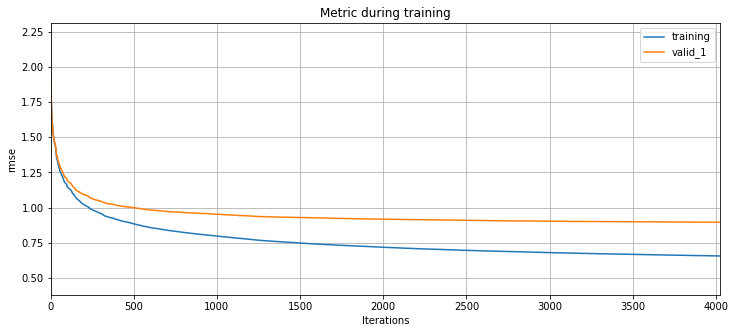

In [56]:
import matplotlib as mlt
import matplotlib.pyplot as plt
%matplotlib inline

lgb.plot_metric(evals_result, figsize=(12, 5))

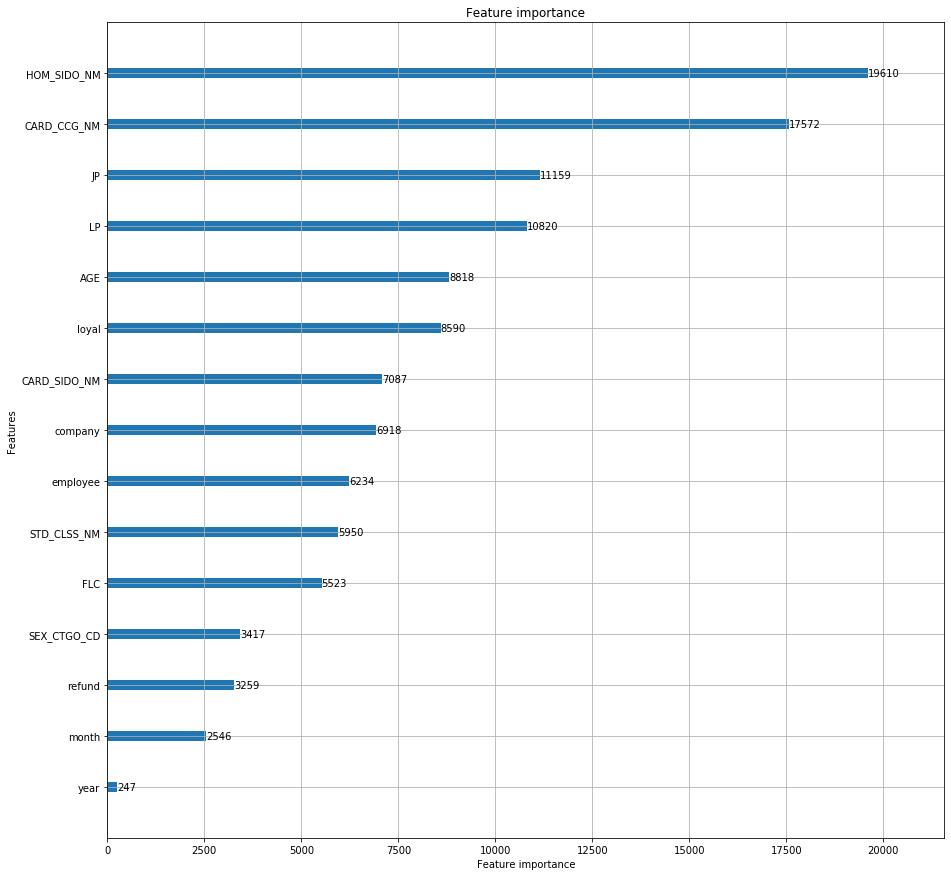

In [57]:
lgb.plot_importance(model, figsize=(15,15))

In [58]:
pred = model.predict(temp)
pred = np.expm1(pred)
temp['AMT'] = np.round(pred, 0)
temp['REG_YYMM'] = temp['year']*100 + temp['month']
temp = temp[['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM', 'AMT']]
temp = temp.groupby(['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM']).sum().reset_index(drop=False)

In [59]:
# 디코딩 (Random Forest)
temp['CARD_SIDO_NM'] = encoders['CARD_SIDO_NM'].inverse_transform(temp['CARD_SIDO_NM'])
temp['STD_CLSS_NM'] = encoders['STD_CLSS_NM'].inverse_transform(temp['STD_CLSS_NM'])

In [60]:
# 제출 파일 만들기(Random Forest)
submission = pd.read_csv('../../Data/Jeju/submission.csv', index_col=0)
submission = submission.drop(['AMT'], axis=1)
submission = submission.merge(temp, left_on=['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM'], right_on=['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM'], how='left')
submission.index.name = 'id'
compare_pred = submission.dropna()
submission = submission.fillna(0)
submission.head()

,REG_YYMM,CARD_SIDO_NM,STD_CLSS_NM,AMT
id,,,,
0,202004,강원,건강보조식품 소매업,6.962430e+07
1,202004,강원,골프장 운영업,5.071241e+09
2,202004,강원,과실 및 채소 소매업,1.045044e+09
3,202004,강원,관광 민예품 및 선물용품 소매업,1.456288e+07
4,202004,강원,그외 기타 분류안된 오락관련 서비스업,0.000000e+00


In [63]:
submission.to_csv('submission/submission_Jaewon_0730.csv', encoding='utf-8-sig')

#### 4월 데이터 없이

In [62]:
# 4, 7월 데이터 = 2020년의 평균값을 사용

temp1 = df_num[df_num['REG_YYMM'] >= '2020']
temp1 = temp1.groupby(['CARD_SIDO_NM', 'CARD_CCG_NM', 'STD_CLSS_NM',
                     'HOM_SIDO_NM', 'AGE', 'SEX_CTGO_CD', 'FLC'], as_index=False)[['company', 'employee', 
                                                            'LP', 'JP', 'loyal', 'month', 'refund', 'year']].mean()

In [67]:
temp2 = temp1.copy()
temp1.month = 4
temp2.month = 7

In [68]:
temp = pd.concat([temp1, temp2])

In [69]:
temp

,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,HOM_SIDO_NM,AGE,SEX_CTGO_CD,FLC,company,employee,LP,JP,loyal,month,refund,year
0,0,4,0,0,1,2,1,263.0,399.0,0.142702,0.254024,93.000000,4,-44.000000,2020.0
1,0,4,0,0,2,1,2,263.0,399.0,0.108962,0.238864,71.000000,4,-33.666667,2020.0
2,0,4,0,0,2,2,2,263.0,399.0,0.142702,0.254024,93.000000,4,-44.000000,2020.0
3,0,4,0,0,3,1,3,263.0,399.0,0.117430,0.265927,77.750000,4,-29.750000,2020.0
4,0,4,0,0,3,1,4,263.0,399.0,0.142702,0.254024,93.000000,4,-44.000000,2020.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
430404,16,202,40,16,3,2,3,11.0,492.0,0.033359,0.056592,585.000000,7,329.666667,2020.0
430405,16,202,40,16,4,1,4,11.0,492.0,0.026140,0.045117,455.500000,7,497.000000,2020.0
430406,16,202,40,16,4,2,4,11.0,492.0,0.033327,0.056300,586.666667,7,329.666667,2020.0
430407,16,202,40,16,5,1,5,11.0,492.0,0.033327,0.056300,586.666667,7,329.666667,2020.0


In [70]:
pred = model.predict(temp)
pred = np.expm1(pred)
temp['AMT'] = np.round(pred, 0)
temp['REG_YYMM'] = temp['year']*100 + temp['month']
temp = temp[['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM', 'AMT']]
temp = temp.groupby(['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM']).sum().reset_index(drop=False)

In [71]:
# 디코딩 (Random Forest)
temp['CARD_SIDO_NM'] = encoders['CARD_SIDO_NM'].inverse_transform(temp['CARD_SIDO_NM'])
temp['STD_CLSS_NM'] = encoders['STD_CLSS_NM'].inverse_transform(temp['STD_CLSS_NM'])

In [72]:
# 제출 파일 만들기(Random Forest)
submission = pd.read_csv('../../Data/Jeju/submission.csv', index_col=0)
submission = submission.drop(['AMT'], axis=1)
submission = submission.merge(temp, left_on=['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM'], right_on=['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM'], how='left')
submission.index.name = 'id'
compare_pred = submission.dropna()
submission = submission.fillna(0)
submission.to_csv('submission/submission lgbm 0728 valid Jan_regression_re_re_non April.csv', encoding='utf-8-sig')

#### 2020 4월 데이터 = 2020 3월데이터

In [96]:
# 4월 데이터 = 2020년 3월 데이터 사용
# 7월 데이터 = 2020년의 평균값을 사용

temp1 = df_num[df_num['REG_YYMM'] == '2020-03-01']
temp1 = temp1.groupby(['CARD_SIDO_NM', 'CARD_CCG_NM', 'STD_CLSS_NM',
                     'HOM_SIDO_NM', 'AGE', 'SEX_CTGO_CD', 'FLC'], as_index=False)[['company', 'employee', 
                                                            'LP', 'JP', 'loyal', 'month', 'refund', 'year']].mean()
temp2 = df_num[df_num['REG_YYMM'] >= '2020-01-01']
temp2 = temp2.groupby(['CARD_SIDO_NM', 'CARD_CCG_NM', 'STD_CLSS_NM',
                     'HOM_SIDO_NM', 'AGE', 'SEX_CTGO_CD', 'FLC'], as_index=False)[['company', 'employee', 
                                                            'LP', 'JP', 'loyal', 'month', 'refund', 'year']].mean()

In [94]:
temp1.month = 4
temp2.month = 7

temp = pd.concat([temp1, temp2])

In [97]:
temp

,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,HOM_SIDO_NM,AGE,SEX_CTGO_CD,FLC,company,employee,LP,JP,loyal,month,refund,year
0,0,4,0,0,2,1,2,263.0,399.0,0.104302,0.256894,70.000000,4,-30.000000,2020.0
1,0,4,0,0,3,1,3,263.0,399.0,0.104302,0.256894,70.000000,4,-30.000000,2020.0
2,0,4,0,0,3,2,3,263.0,399.0,0.104302,0.256894,70.000000,4,-30.000000,2020.0
3,0,4,0,0,4,1,4,263.0,399.0,0.104302,0.256894,70.000000,4,-30.000000,2020.0
4,0,4,0,0,4,2,4,263.0,399.0,0.104302,0.256894,70.000000,4,-30.000000,2020.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
430404,16,202,40,16,3,2,3,11.0,492.0,0.033359,0.056592,585.000000,7,329.666667,2020.0
430405,16,202,40,16,4,1,4,11.0,492.0,0.026140,0.045117,455.500000,7,497.000000,2020.0
430406,16,202,40,16,4,2,4,11.0,492.0,0.033327,0.056300,586.666667,7,329.666667,2020.0
430407,16,202,40,16,5,1,5,11.0,492.0,0.033327,0.056300,586.666667,7,329.666667,2020.0


In [98]:
pred = model.predict(temp)
pred = np.expm1(pred)
temp['AMT'] = np.round(pred, 0)
temp['REG_YYMM'] = temp['year']*100 + temp['month']
temp = temp[['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM', 'AMT']]
temp = temp.groupby(['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM']).sum().reset_index(drop=False)

In [99]:
# 디코딩 (Random Forest)
temp['CARD_SIDO_NM'] = encoders['CARD_SIDO_NM'].inverse_transform(temp['CARD_SIDO_NM'])
temp['STD_CLSS_NM'] = encoders['STD_CLSS_NM'].inverse_transform(temp['STD_CLSS_NM'])

In [100]:
# 제출 파일 만들기(Random Forest)
submission = pd.read_csv('../../Data/Jeju/submission.csv', index_col=0)
submission = submission.drop(['AMT'], axis=1)
submission = submission.merge(temp, left_on=['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM'], right_on=['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM'], how='left')
submission.index.name = 'id'
compare_pred = submission.dropna()
submission = submission.fillna(0)
submission.to_csv('submission/submission lgbm 0728 valid Jan_regression_re_re_non April_March.csv', encoding='utf-8-sig')